# Speech Emotion Recognition using librosa


In [1]:
!pip install librosa

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/aksultan/.local/include/python3.8/UNKNOWN
sysconfig: /home/aksultan/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Загрузка одного аудиофайла с помощью librosa.
Librosa загружает аудиофайл как временной ряд

In [2]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('examples/03-01-01-01-01-02-05.wav')

Построение аудиофайла, который только что был загружен librosa, с использованием функции волнового графика librosa. Эта функция строит огибающую амплитуды волны.

In [3]:
% pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


# Load all files

Мы создадим наш массив numpy, извлекающий кепстральные коэффициенты Mel-частоты (MFCC), в то время как классы для прогнозирования будут извлечены из имени файла

In [6]:
import time
import os
import numpy as np
path = 'examples/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Загрузите массив librosa, получите mfcss, сохраните файл и информацию mcss в новом массиве
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # Инструкция ниже преобразует метки (от 1 до 8) в серию от 0 до 7
# Это потому, что нашему предиктору нужно начинать с 0, иначе он также попытается предсказать 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.09074068069458008 seconds ---


In [7]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [8]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2, 40), (2,))

In [9]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'examples/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [10]:
# Loading saved models
import joblib
X = joblib.load('dataset_features/X.joblib')
y = joblib.load('dataset_features/y.joblib')

# Decision Tree Classifier

Чтобы сделать первую попытку выполнить эту задачу классификации, я выбрал дерево решений:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
dtree = DecisionTreeClassifier()

In [14]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
predictions = dtree.predict(X_test)

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       192
           1       0.63      0.55      0.59       123
           2       0.60      0.63      0.62       264
           3       0.73      0.67      0.70       275
           4       0.70      0.71      0.70       252
           5       0.63      0.64      0.63       241
           6       0.70      0.72      0.71       197
           7       0.56      0.57      0.57       190

    accuracy                           0.67      1734
   macro avg       0.67      0.66      0.66      1734
weighted avg       0.67      0.67      0.67      1734



# Neural network

In [17]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [18]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

In [20]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
# optimizer = keras.optimizers.RMSprop(lr=0.0003, decay=1e-6)
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)          

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
220/220 [==============================] - 1s 3ms/step - loss: 5.2613 - accuracy: 0.1287 - val_loss: 1.8035 - val_accuracy: 0.3512
Epoch 2/200
220/220 [==============================] - 1s 3ms/step - loss: 2.5813 - accuracy: 0.2708 - val_loss: 1.4748 - val_accuracy: 0.4550
Epoch 3/200
220/220 [==============================] - 1s 3ms/step - loss: 1.9235 - accuracy: 0.4045 - val_loss: 1.4097 - val_accuracy: 0.5098
Epoch 4/200
220/220 [==============================] - 1s 3ms/step - loss: 1.6407 - accuracy: 0.4475 - val_loss: 1.2237 - val_accuracy: 0.5669
Epoch 5/200
220/220 [==============================] - 1s 4ms/step - loss: 1.4719 - accuracy: 0.5080 - val_loss: 1.1869 - val_accuracy: 0.5750
Epoch 6/200
220/220 [==============================] - 2s 7ms/step - loss: 1.3974 - accuracy: 0.5242 - val_loss: 1.1721 - val_accuracy: 0.5819
Epoch 7/200
220/220 [==============================] - 1s 4ms/step - loss: 1.2495 - accuracy: 0.5803 - val_loss: 1.0838 - val_accuracy: 0.6251

Epoch 58/200
220/220 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.7721 - val_loss: 0.6059 - val_accuracy: 0.7739
Epoch 59/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5903 - accuracy: 0.7738 - val_loss: 0.5903 - val_accuracy: 0.7791
Epoch 60/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5785 - accuracy: 0.7784 - val_loss: 0.6077 - val_accuracy: 0.7728
Epoch 61/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5649 - accuracy: 0.7849 - val_loss: 0.5854 - val_accuracy: 0.7901
Epoch 62/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5879 - accuracy: 0.7863 - val_loss: 0.5848 - val_accuracy: 0.7820
Epoch 63/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5671 - accuracy: 0.7956 - val_loss: 0.5811 - val_accuracy: 0.7860
Epoch 64/200
220/220 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.7777 - val_loss: 0.5808 - val_accuracy:

Epoch 115/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4359 - accuracy: 0.8315 - val_loss: 0.4942 - val_accuracy: 0.8166
Epoch 116/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4144 - accuracy: 0.8512 - val_loss: 0.4914 - val_accuracy: 0.8206
Epoch 117/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4083 - accuracy: 0.8443 - val_loss: 0.5159 - val_accuracy: 0.8085
Epoch 118/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.8547 - val_loss: 0.4883 - val_accuracy: 0.8160
Epoch 119/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4017 - accuracy: 0.8520 - val_loss: 0.4912 - val_accuracy: 0.8241
Epoch 120/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.8398 - val_loss: 0.4831 - val_accuracy: 0.8195
Epoch 121/200
220/220 [==============================] - 1s 3ms/step - loss: 0.4208 - accuracy: 0.8412 - val_loss: 0.5020 - val_ac

220/220 [==============================] - 1s 3ms/step - loss: 0.3104 - accuracy: 0.8920 - val_loss: 0.4683 - val_accuracy: 0.8310
Epoch 172/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3302 - accuracy: 0.8817 - val_loss: 0.4641 - val_accuracy: 0.8374
Epoch 173/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3015 - accuracy: 0.8870 - val_loss: 0.4511 - val_accuracy: 0.8258
Epoch 174/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3413 - accuracy: 0.8780 - val_loss: 0.4541 - val_accuracy: 0.8310
Epoch 175/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3066 - accuracy: 0.8854 - val_loss: 0.4571 - val_accuracy: 0.8304
Epoch 176/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3214 - accuracy: 0.8880 - val_loss: 0.4502 - val_accuracy: 0.8322
Epoch 177/200
220/220 [==============================] - 1s 3ms/step - loss: 0.3063 - accuracy: 0.8931 - val_loss: 0.4540 - val_accuracy: 0.8328

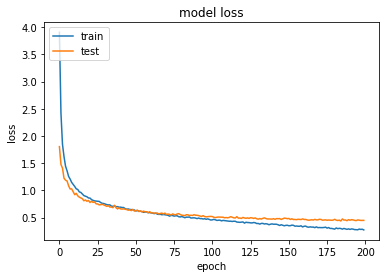

In [25]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

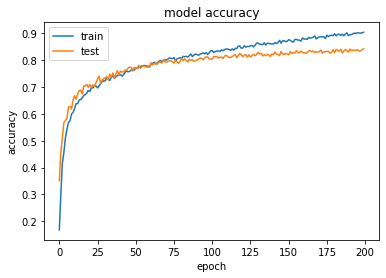

In [26]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
predictions = model.predict_classes(x_testcnn)

/home/aksultan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
predictions

array([3, 3, 3, ..., 1, 6, 2])

In [29]:
y_test

array([3, 3, 3, ..., 1, 6, 2], dtype=int32)

In [30]:
new_Ytest = y_test.astype(int)

In [31]:
new_Ytest

array([3, 3, 3, ..., 1, 6, 2])

In [32]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       192
           1       0.73      0.82      0.77       123
           2       0.80      0.82      0.81       264
           3       0.91      0.76      0.83       275
           4       0.87      0.91      0.89       252
           5       0.82      0.83      0.82       241
           6       0.88      0.86      0.87       197
           7       0.82      0.86      0.84       190

    accuracy                           0.84      1734
   macro avg       0.84      0.84      0.84      1734
weighted avg       0.84      0.84      0.84      1734



In [33]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[169   7   4   4   1   1   1   5]
 [  4 101  12   0   0   3   2   1]
 [  1  12 217   0  13  12   3   6]
 [  6   9  14 210   6  17   5   8]
 [  2   2   5   0 229   5   6   3]
 [  5   1   8  14   8 200   2   3]
 [  5   5   3   0   3   1 170  10]
 [  1   1   8   2   4   5   5 164]]


In [34]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [35]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)          

In [36]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

55/55 [==============================] - 0s 945us/step - loss: 0.4474 - accuracy: 0.8420
Restored model, accuracy: 84.20%
